# Imports

In [51]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.exposure import equalize_adapthist
from skimage.filters._unsharp_mask import unsharp_mask
from skimage.morphology import binary_closing, binary_dilation
from skimage.morphology import square, disk

from src.fish import range_filter
from src.models import InputImage
from src.utils import normalize_0_1, keep_largest_object
from src.well import find_well_props

In [52]:
uniform_fig = (60, 40)

# Functions

In [53]:
def plot_images(images, cols: int = None, count: int = None, fig: (int, int) = (16, 16), ticks=False, cmap='binary',
                title=None, hist=False, nums=False):
    if count is not None:
        images = images[0:count]

    l = len(images)

    if cols is None:
        cols = 4

    rows = int(l / cols)
    if l < cols: cols = l
    if l % cols != 0 or rows == 0:
        rows += 1

    fig, ax = plt.subplots(rows, cols, figsize=fig)
    ax = ax.ravel()
    for i, img in enumerate(images):
        if i >= l: return

        if nums: ax[i].set_title(f'#{i}')

        if not hist:
            ax[i].imshow(img, cmap)
            if not ticks:  # turn off ticks
                ax[i].get_xaxis().set_visible(False)
                ax[i].get_yaxis().set_visible(False)
        else:
            ax[i].hist(img.ravel(), bins=256)
    fig.suptitle(title, fontsize=56)
    plt.tight_layout()

In [54]:
def plot_fishes(fishes, cols: int = None, count: int = None, fig: (int, int) = (16, 16), ticks=False, cmap='binary'):
    images = list(map(lambda x: x.processed, fishes))  # Change this!
    plot_images(images, cols, count, fig, ticks, cmap)

# RUN!!!

# Fishes in extracted wells

In [55]:
import os

os.chdir('C:\\Users\\gimes\\source\\repos\\zebra_fishy\\src\\models\\images\\in')
fish_names = os.listdir()
os.chdir('C:\\Users\\gimes\\source\\repos\\zebra_fishy\\src\\fish')

In [56]:
fishes = []
fishes.append(InputImage('zf5.jpg'))
for name in fish_names[0:7]:
    fishes.append(InputImage(name))

#[InputImage("zf11.JPG"), InputImage("zf12.JPG"), InputImage("zf13.JPG"), InputImage("zf14.JPG"), InputImage("zf15.JPG"), InputImage("zf16.JPG"), InputImage("zf9.JPG"), InputImage("zf10.JPG")]

#[InputImage("zf21.JPG"), InputImage("zf22.JPG"), InputImage("zf23.JPG"), InputImage("zf24.JPG"), InputImage("zf25.JPG"), InputImage("zf26.JPG"), InputImage("zf29.JPG"), InputImage("zf20.JPG")]
#fishes = [InputImage("zf1.JPG"), InputImage("zf2.JPG"), InputImage("zf3.JPG"), InputImage("zf4.JPG"), InputImage("zf5.JPG"), InputImage("zf6.JPG"), InputImage("zf7.JPG"), InputImage("zf8.JPG")]"""
fishes = [InputImage("zf2.JPG"), InputImage("zf3.JPG"), InputImage("zf5.JPG"), InputImage("zf7.JPG")]

for i, fish in enumerate(fishes):
    print(f'#{i}')
    fish = find_well_props(fish)

#0
# Searching for well properties
_____________________________________________________________
# Hough-transformation for the well
_____________________________________________________________
# Hough-transformation finished
_____________________________________________________________
# Creating circle mask for well
_____________________________________________________________
# Circle mask for well created
_____________________________________________________________
# Creating remaining masks:
_____________________________________________________________
# Creating cropped mask
_____________________________________________________________
# Creating masked image (original)
_____________________________________________________________
# Creating masked image (cropped)
_____________________________________________________________
# Created remaining masks
_____________________________________________________________
#1
# Searching for well properties
________________________________

In [57]:
masks = []
maskeds = []
for fish in fishes:
    masks.append(fish.well_props.mask.cropped)
    maskeds.append(fish.well_props.mask.cropped_masked)

# Rangefilter*
With all available

In [58]:
from skimage.exposure import adjust_gamma

edge = []
edge_ = []

for fish in fishes:
    eq = unsharp_mask(fish.processed, radius=1.25)  # sharpening
    rngfilter = range_filter(eq)

    n = normalize_0_1(rngfilter)
    edge.append(equalize_adapthist(n))
    edge_.append(adjust_gamma(equalize_adapthist(n), gamma=1.5))

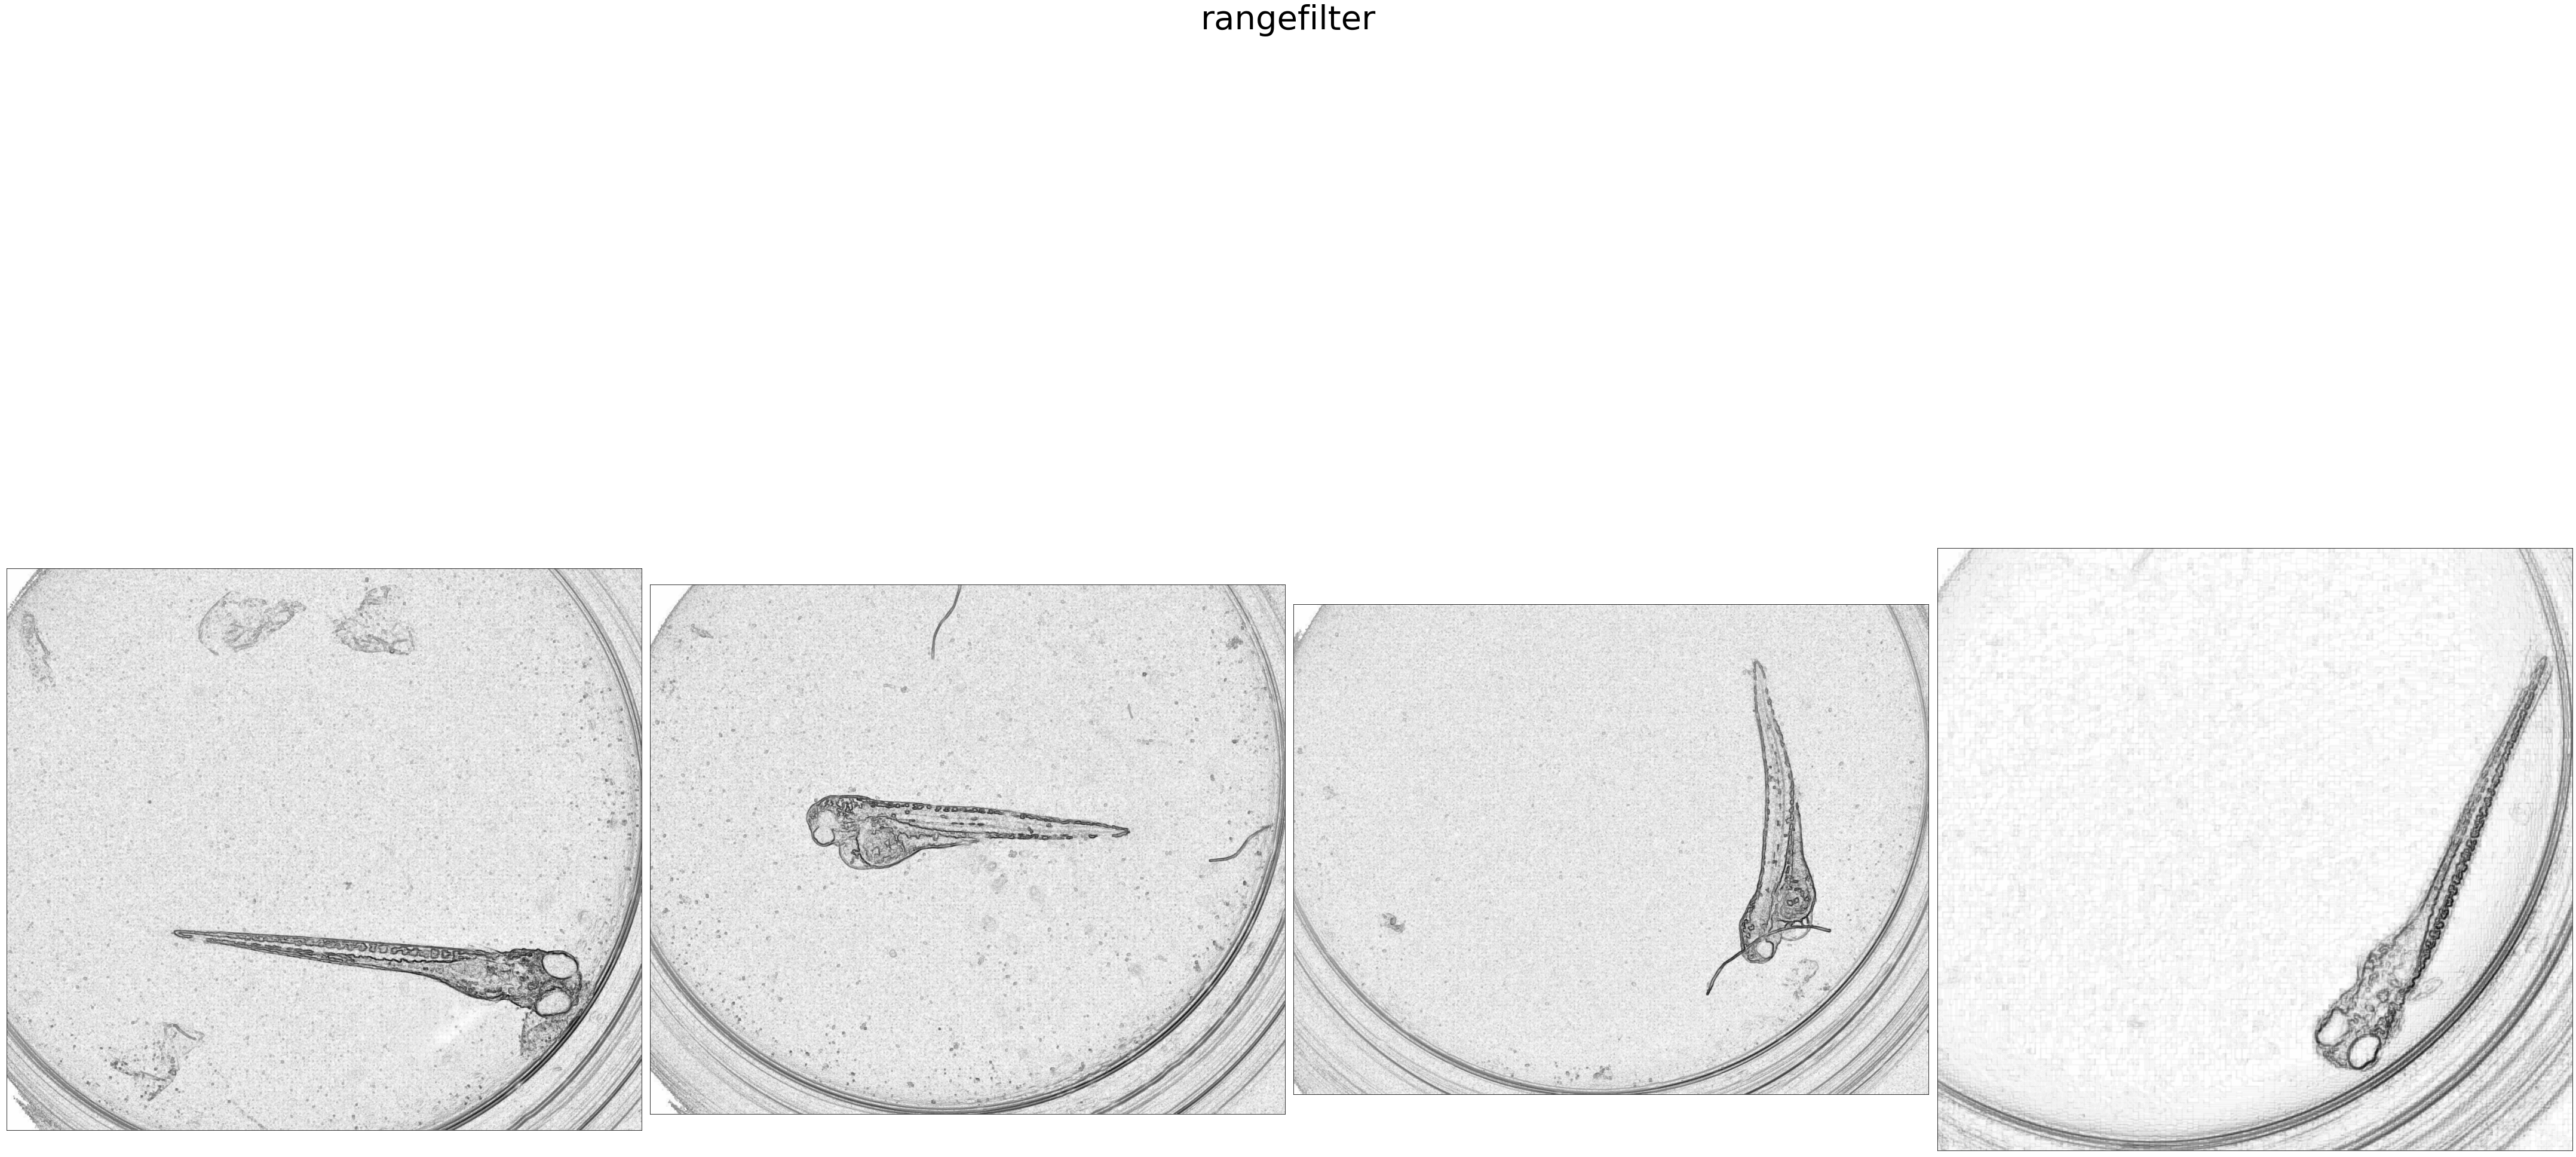

In [59]:
# plot_fishes(fishes, fig=(20, 10))
hist = False
plot_images(edge, fig=uniform_fig, cmap='binary', title='rangefilter', hist=hist)

# Wiener filter*

In [60]:
from src.utils import normalize_0_255
from scipy.signal import wiener
from skimage.exposure import equalize_hist

denoised = []
# for fish in fishes:
#    fish.processed = denoising(fish.processed) # wiener filter
for i, fish in enumerate(edge_):
    w = wiener(fish, 25) * masks[i]
    norm = normalize_0_255(w)
    sh = unsharp_mask(norm, radius=2, amount=2)
    denoised.append(sh)


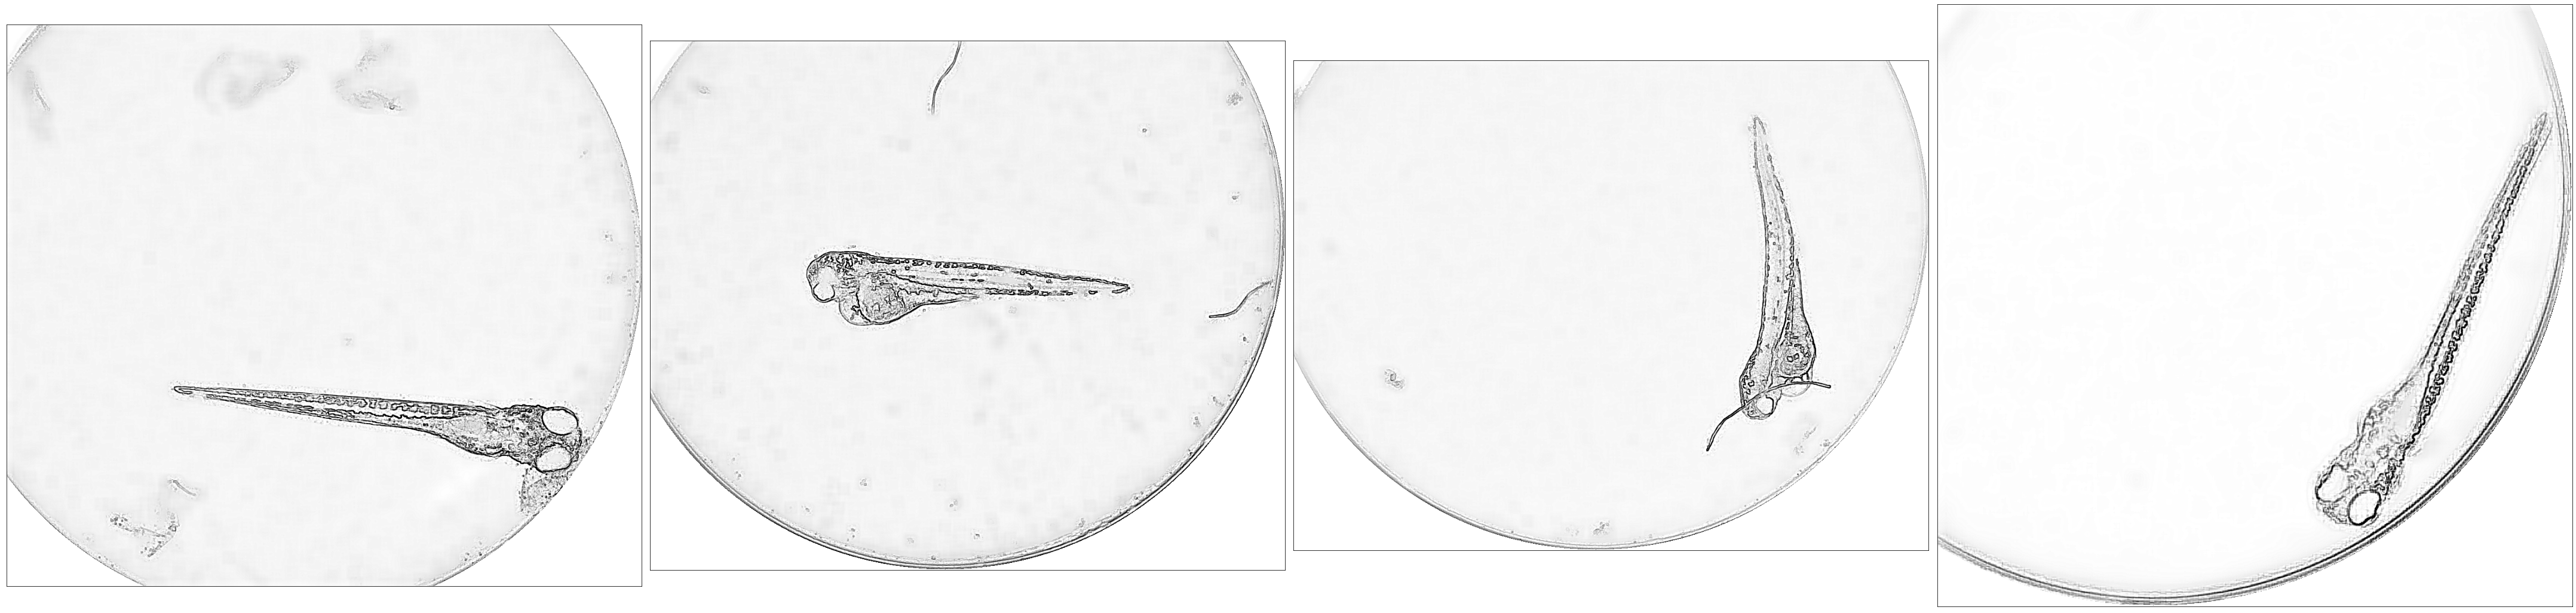

In [61]:
# plot_fishes(fishes, fig=uniform_fig)
plot_images(denoised, fig=uniform_fig)

# threshold

In [62]:
from src.utils import yen_th

ath = []
# for fish in fishes:
# fish.processed = adaptiveTh(fish.processed)
for i, fish in enumerate(denoised):
    # might need area-opening here
    th = yen_th(fish)
    ath.append(th)

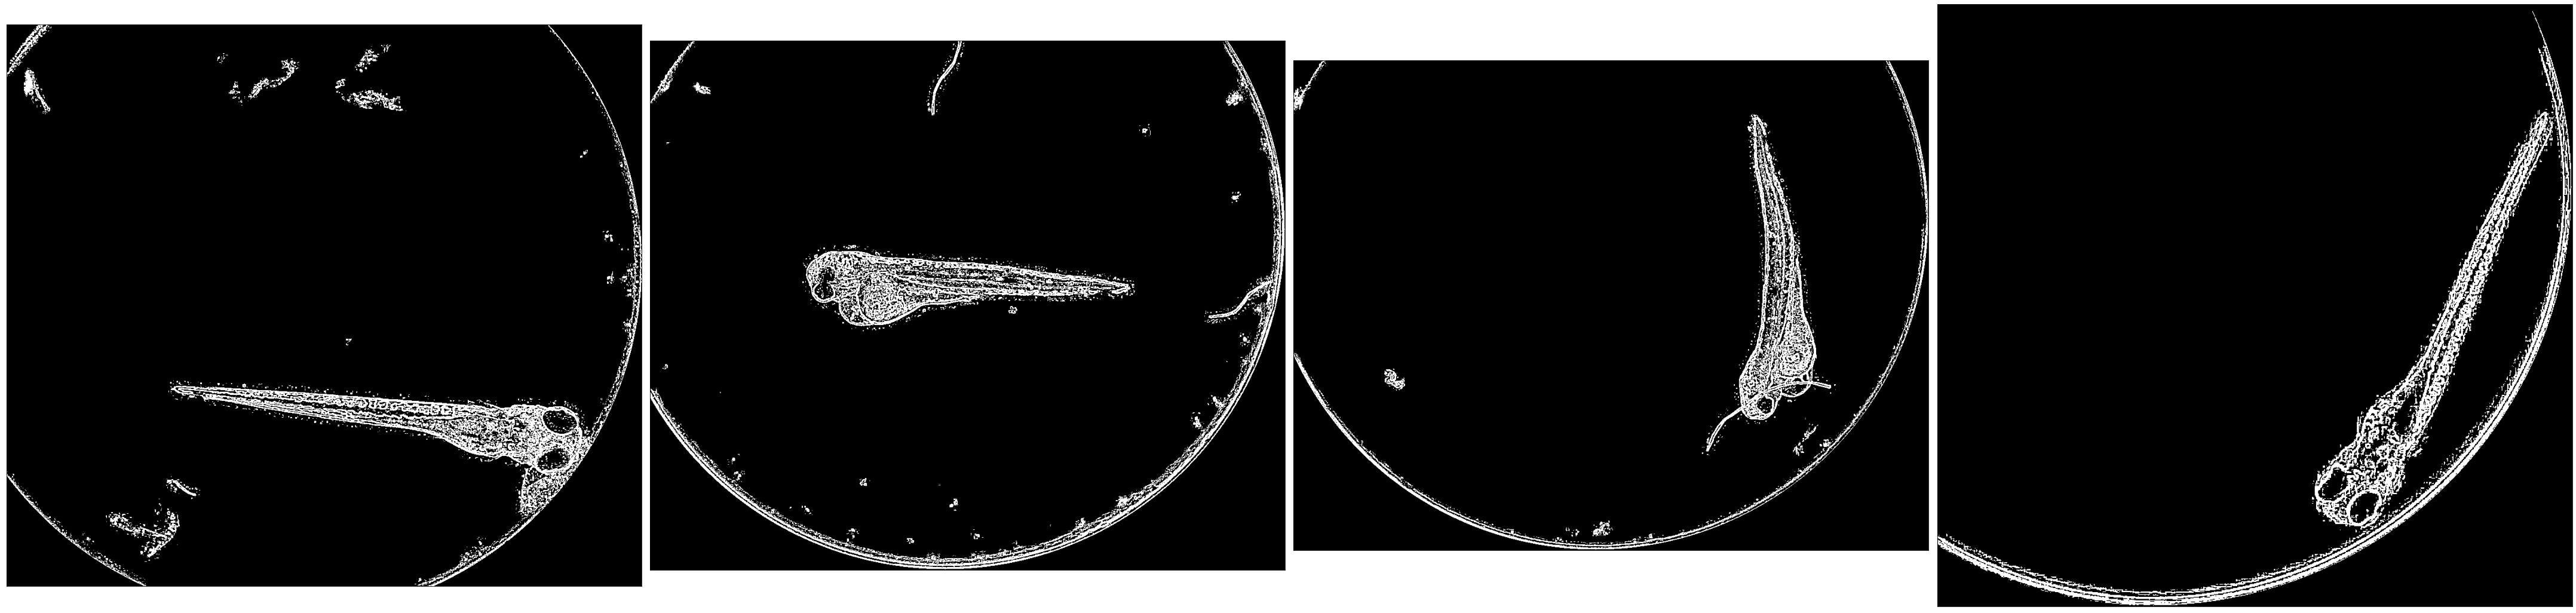

In [63]:
# plot_fishes(fishes, fig=(20, 10))
plot_images(ath, fig=uniform_fig, cmap='gray')

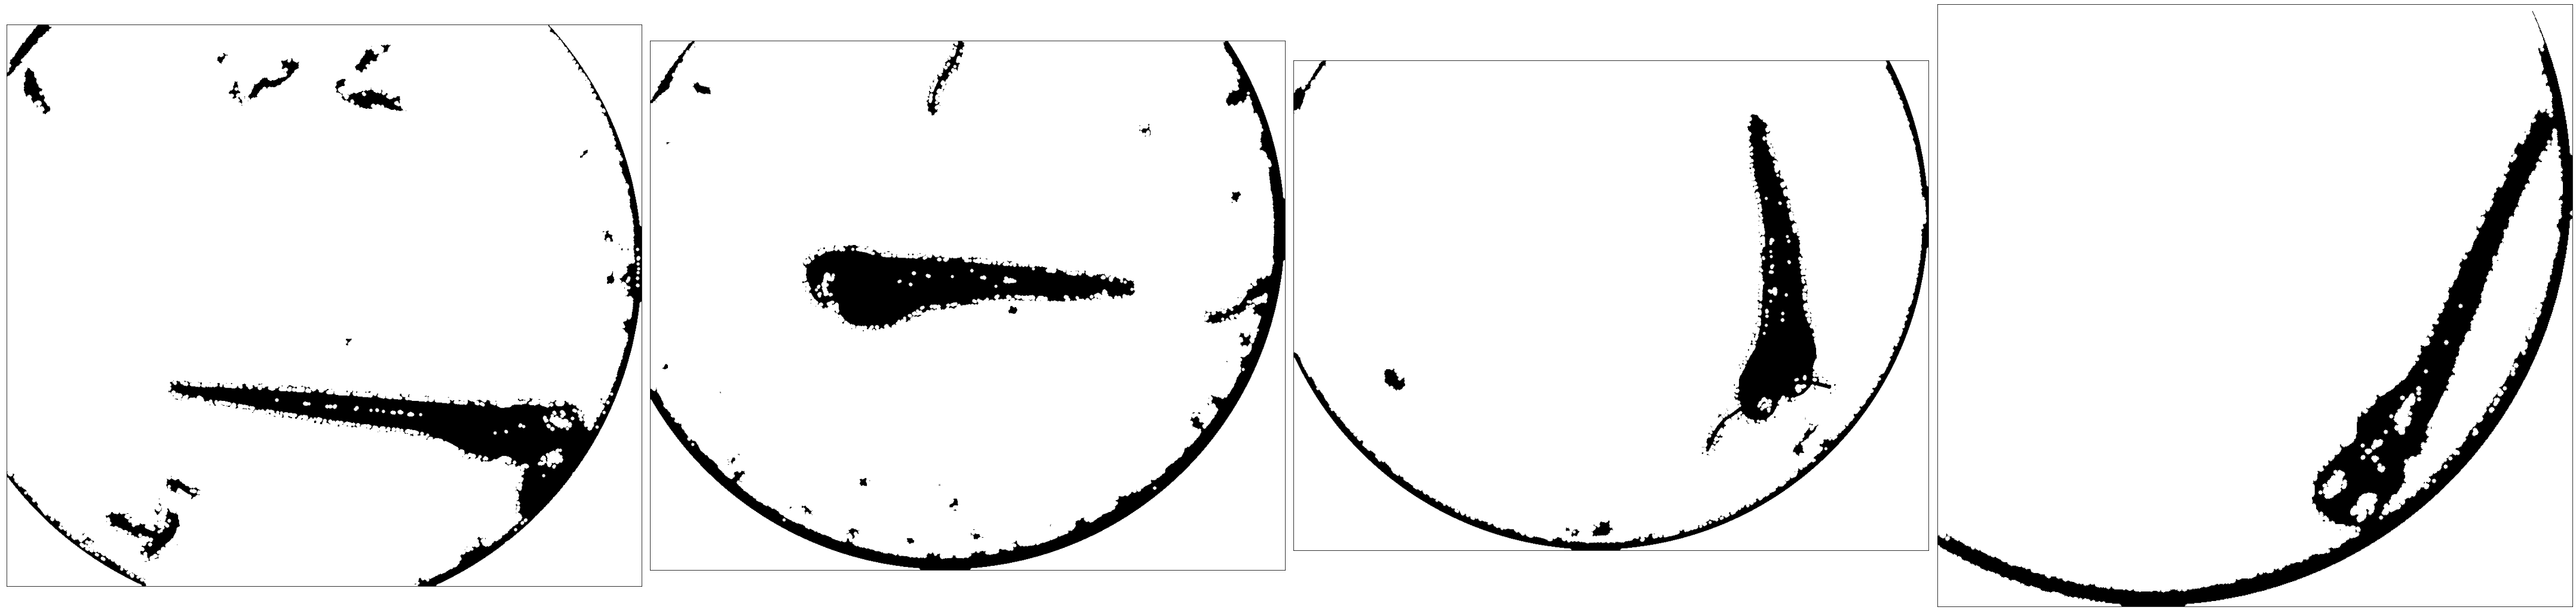

In [64]:
from skimage.morphology import remove_small_holes

close = []
for i, fish in enumerate(ath):
    close.append((binary_closing(fish, disk(3))))

plot_images(close, fig=uniform_fig)

# Removing meniscus


Fish no.1
max: 5
Fish no.2
max: 9
Fish no.3
max: 5
Fish no.4
max: 9


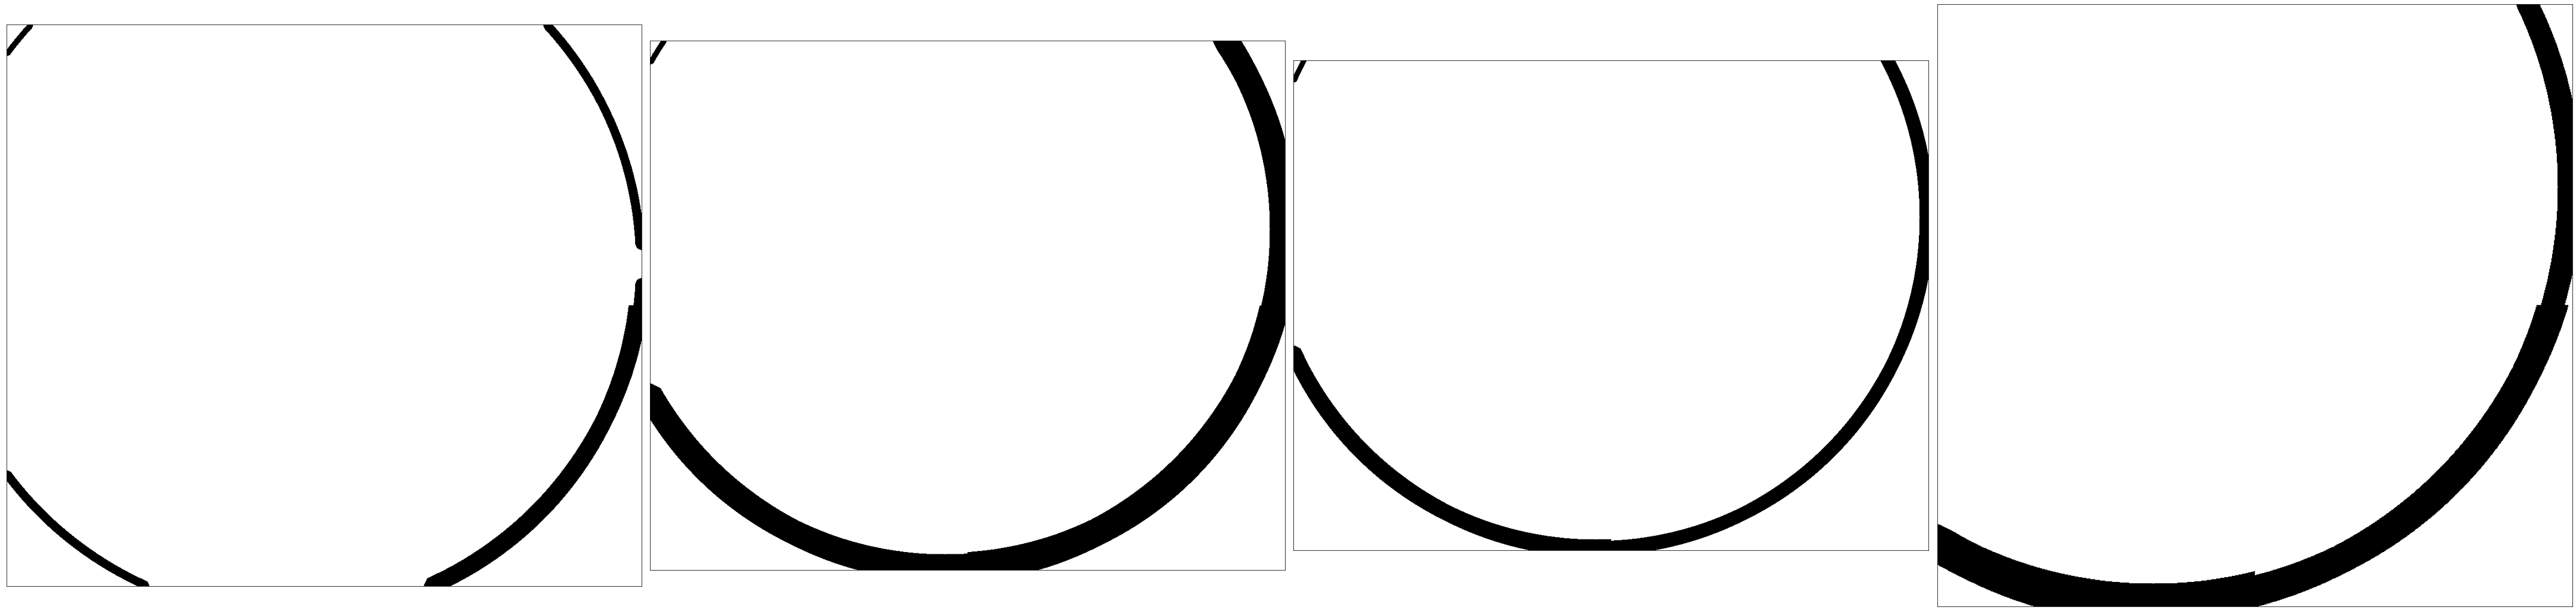

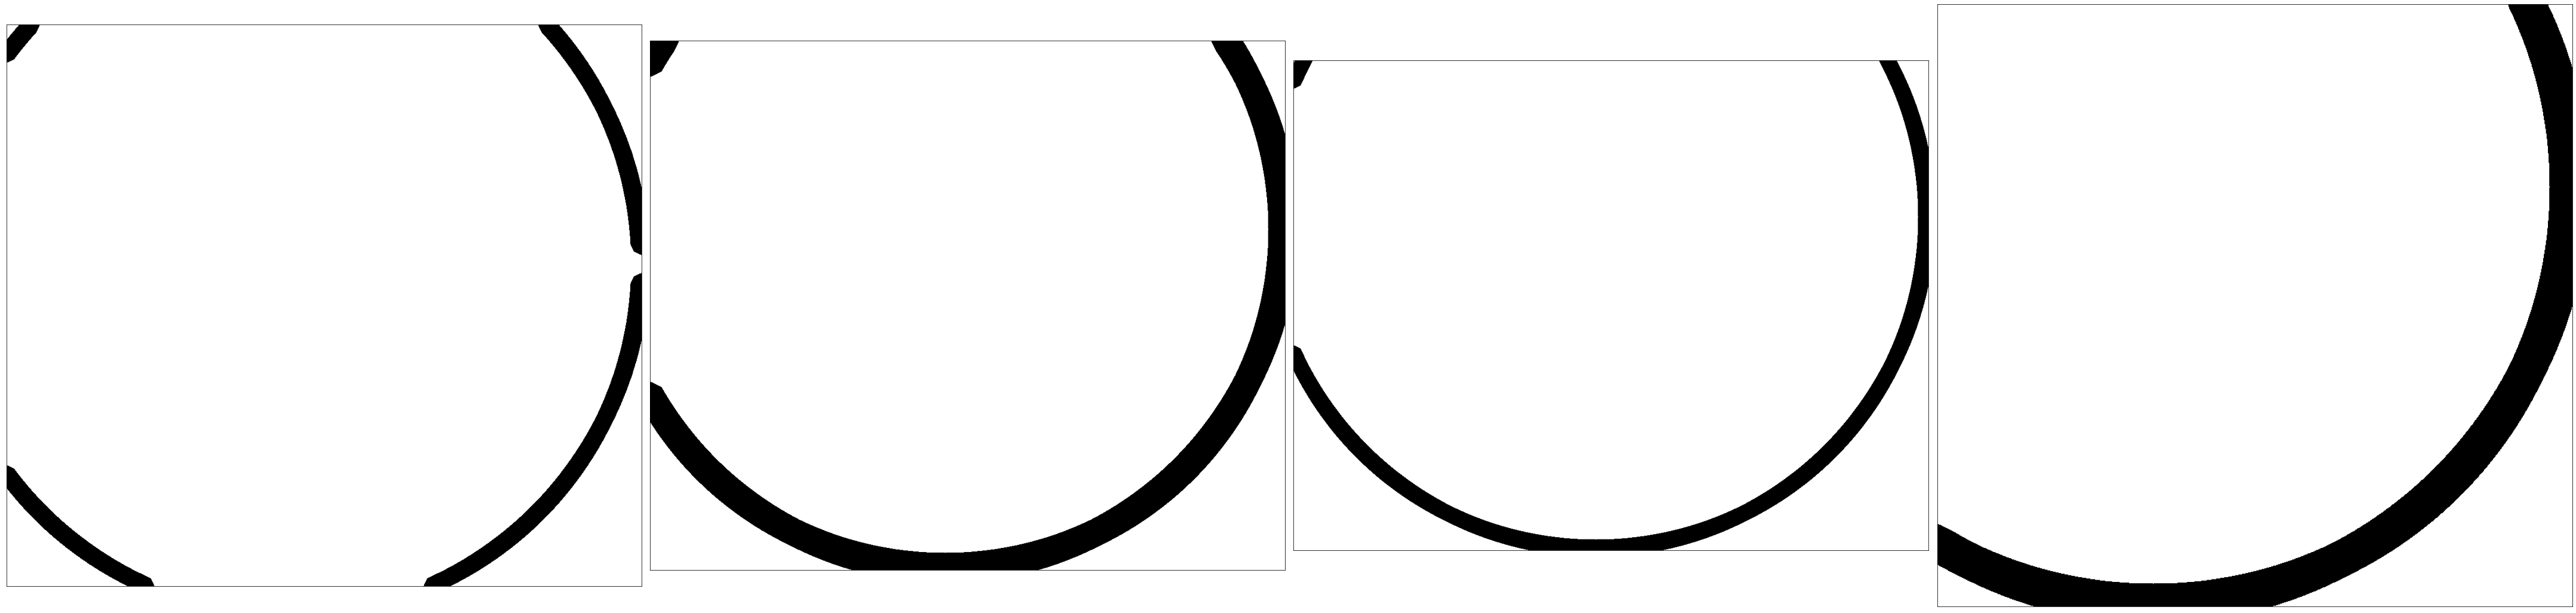

In [67]:
from src.fish import get_meniscus_effect_, get_meniscus_effect__
from src.utils import show_img

menisci = []
menisci_ = []
no_menisci_ = []
no_menisci = []
for i, fish in enumerate(close):
    print(f"Fish no.{i + 1}")
    men = get_meniscus_effect_(fish, masks[i])
    meni = get_meniscus_effect__(fish, masks[i])
    """if not is_fish(a):
        a = a + get_meniscus_effect(a, dilation(masks[i]),square(10))"""
    menisci.append(men)
    menisci_.append(meni)

for i, meniscus in enumerate(menisci):
    no_menisci.append(close[i] * meniscus)
    no_menisci_.append(close[i] ^ no_menisci[i])

plot_images(menisci_, fig=uniform_fig, cmap='binary')
plot_images(menisci, fig=uniform_fig, cmap='binary')

In [ ]:
"""from src.fish import is_fish
from skimage.morphology import convex_hull_image
from src.utils import keep_largest_object_convex, keep_largest_object

for i, menisc in enumerate(no_menisci_):
    a = keep_largest_object_convex(menisc)
    if not is_fish(a):
        b = keep_largest_object(masks[i] ^ menisci[i])
        me = get_meniscus_effect_(no_menisci_[i], b)

        no_menisci.append()
        show_img()"""

In [1]:
i = 3

l = [close[i], menisci_[i], menisci[i], menisci[i].astype(float) + close[i].astype(float) +]
plot_images(l, cmap='gray')

SyntaxError: invalid syntax (1514989891.py, line 3)

In [74]:
def get_mask_from_meniscus(meniscus: np.ndarray) -> np.ndarray:
    inv = ~meniscus
    return keep_largest_object(inv)

# plot_images(menisci)

# plt.imshow(get_mask_from_meniscus(menisci[5]), 'gray')

In [ ]:
plot_images(no_menisci, fig=uniform_fig, cmap='binary')
plot_images(no_menisci_, fig=uniform_fig, cmap='binary')

In [ ]:
from src.utils import keep_largest_object

klo = []
for i, fish in enumerate(no_menisci_):
    klo.append(binary_closing(keep_largest_object(fish, filled=True), disk(3)))

In [ ]:
plot_images(klo, fig=uniform_fig)

In [ ]:
from skimage.morphology import convex_hull_image
from src.fish import iterative_dilation
from src.models import BoundingBox
from src.utils import keep_largest_object_convex, get_bounding_box_obj

new_in_bbox = []
new_masks = []
bboxes = []
convexes_inner = []
convexes_outer = []

for i, fish in enumerate(klo):
    convex_mask = convex_hull_image(fish)
    convex_mask = iterative_dilation(convex_mask, 10, square(5))

    input_img = fishes[i]

    bbox_ = get_bounding_box_obj(convex_mask)

    bbox = BoundingBox(input_img.well_props.bounding_box.x1 + bbox_.x1,
                       input_img.well_props.bounding_box.y1 + bbox_.y1,
                       input_img.well_props.bounding_box.x1 + bbox_.x2,
                       input_img.well_props.bounding_box.y1 + bbox_.y2)

    im = input_img.og[bbox.x1:bbox.x2, bbox.y1:bbox.y2]
    mask = fish[bbox_.x1:bbox_.x2, bbox_.y1:bbox_.y2]

    input_img.fish_props.bounding_box = bbox
    input_img.fish_props.mask.cropped_masked = im

    bboxes.append(bbox)
    convexes_outer.append(convex_mask)
    convexes_inner.append(bbox_.bound_img(convex_mask))

    new_masks.append(mask)
    new_in_bbox.append(-unsharp_mask(im))

In [ ]:
from skimage.morphology import thin, skeletonize

c_maskeds = []
c_maskeds_ = []

for i, fish in enumerate(klo):
    c_maskeds.append((keep_largest_object_convex(fish)))

    c_maskeds_.append(fish)  #(keep_largest_object_convex(fish)))
    c_maskeds_.append((thin(fish)))
    c_maskeds_.append(skeletonize(fish))

plot_images(c_maskeds_, 3, fig=(15, 30))

In [ ]:
plot_images(new_masks, fig=uniform_fig)
plot_images(new_in_bbox, fig=uniform_fig, cmap='gray')

_________________________________

# Testies

In [ ]:
from src.fish.get_head import get_two_sides_img
from src.fish import get_head

halves = []

for i, fish in enumerate(convexes_inner):
    if fish.shape[0] > fish.shape[1]: fish = np.transpose(fish)
    men = get_head(new_masks[i])
    m_l, m_r = get_two_sides_img(new_in_bbox[i])

    l, r = get_two_sides_img(new_in_bbox[i] * c_maskeds[i])

    if men[1] == 'l':
        halves.append((m_l * l))
    elif men[1] == 'r':
        halves.append((m_r * r))

plot_images(halves, fig=uniform_fig)